In [ ]:
!pip install tensorflow==2.3.0

In [ ]:
import os
import sys
sys.path.append("../")
from dana import models as dana_models
from dana import trainers as dana_trainers
import numpy as np
import tensorflow as tf
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.3.0


In [ ]:
## Download and UnZip UTwente Dataset into the Path: dana/datasets/Utwente
## https://www.utwente.nl/en/eemcs/ps/dataset-folder/ut-data-complex.rar
from dana.datasets import utwente
(X_train, Y_train, X_test, Y_test, data_class_names, data_class_weights) = utwente.load_data(shuffle=False)

rnd_seed = 0
tf.random.set_seed(rnd_seed)
np.random.RandomState(seed=rnd_seed).permutation(len(X_train))
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
Y_train = Y_train[indices] 

X_train = np.expand_dims(X_train,3)
X_test = np.expand_dims(X_test,3)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print("Activity Weights",dict(zip(data_class_names,data_class_weights.values())))

(14611, 128, 9, 1) (14611,) (3634, 128, 9, 1) (3634,)
Activity Weights {'walk': 0.9999, 'stand': 0.9999, 'jog': 0.9999, 'sit': 0.9999, 'bike': 0.9999, 'ups': 0.9999, 'downs': 0.9999, 'type': 0.9999, 'write': 0.9999, 'coffee': 0.9999, 'talk': 0.9999, 'smoke': 0.9999, 'eat': 1.0008}


In [ ]:
def test_model(model, X_val, Y_val, batch_size, W_comb=None, H_comb=None):
    if not W_comb:
        W_comb = X_val.shape[1]
    if not H_comb:
        H_comb = list(range(X_val.shape[2]))
    val_accuracy = tf.keras.metrics.Accuracy()
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
    val_dataset = val_dataset.batch(batch_size)        
    for (X, Y) in val_dataset:
        X = X.numpy()                                    
        X = X[:,:,H_comb,:]                     
        X = tf.image.resize(X, (W_comb, len(H_comb)))
        logits = model(X)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        val_accuracy(prediction, Y)        
    return val_accuracy.result()

In [ ]:
W_combinations = list(np.arange(16,129,16))
H_combinations = [[0,1,2], [3,4,5], [6,7,8], 
                  [0,1,2,3,4,5], [0,1,2,6,7,8],
                  [3,4,5,0,1,2], [3,4,5,6,7,8],
                  [6,7,8,0,1,2], [6,7,8,3,4,5],
                  [0,1,2,3,4,5,6,7,8],[0,1,2,6,7,8,3,4,5],
                  [3,4,5,0,1,2,6,7,8],[3,4,5,6,7,8,0,1,2], 
                  [6,7,8,3,4,5,0,1,2],[6,7,8,0,1,2,3,4,5]] ## Acc & Gyr & Mgn

W_combinations_validation = W_combinations
H_combinations_validation = [[0,1,2], [3,4,5], [6,7,8], 
                  [0,1,2,3,4,5], [0,1,2,6,7,8],[3,4,5,6,7,8],
                  [0,1,2,3,4,5,6,7,8]]
n_batch_per_train_setp = 5

In [ ]:
runs = np.arange(1,2)
for run in runs:
    ## ["standard", "reptile", "weight_avg", "dat"]
    for method in  ["dat"]:   
        history_accuracy = []
        history_time = []
        model = dana_models.Ordonez2016DeepWithDAP((None, None, 1), len(np.unique(Y_train)), (8,9))
        print(model.summary())

        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        optimizer = tf.keras.optimizers.Adam()
        # print("**__** Run {} -- Method {}".format(run, method))
        trainer = dana_trainers.ModelTrainer(model, loss_fn, optimizer, data_class_weights,
                                              num_epochs=1000, batch_size=128, patience=100,
                                              W_combinations=W_combinations,
                                              H_combinations=H_combinations,
                                              W_combinations_validation=W_combinations_validation,
                                              H_combinations_validation=H_combinations_validation,
                                              n_batch_per_train_setp=n_batch_per_train_setp)
        save_dir_model="saved_models/exp_ut_dana/Ordonez2016DeepWithDAP_2_"+method+"_"+\
              str((len(W_combinations),len(H_combinations),n_batch_per_train_setp))+"/best_"+str(run)
       
        ##### Uncomment this if you want to train the model
        # _, best_accuracy_record, avg_training_time = trainer.train_model(X_train[len(X_train)//10:], Y_train[len(X_train)//10:],
        #                                                                  X_train[:len(X_train)//10], Y_train[:len(X_train)//10],
        #                                                                  method,
        #                                                                  save_dir=save_dir_model,
        #                                                                  verbose=10)

        # history_accuracy.append(best_accuracy_record)
        # history_time.append(avg_training_time)
        # save_dir_results = "saved_models/exp_ut_dana/Ordonez2016DeepWithDAP_2_"+method+"_"+\
        #     str((len(W_combinations),len(H_combinations),n_batch_per_train_setp))
        # if not os.path.exists(save_dir_results):
        #     os.makedirs(save_dir_results)
        # np.save(save_dir_results+"/accuracy_results_"+str(run)+".npy", history_accuracy)
        # np.save(save_dir_results+"/timing_results_"+str(run)+".npy", history_time)
        #####

        model.load_weights(save_dir_model)   
        best_accuracy_record = np.zeros((len(W_combinations_validation),len(H_combinations_validation)))
        for w in range(len(W_combinations_validation)):
            for h in range(len(H_combinations_validation)):                    
                best_accuracy_record[w,h] = test_model(model, X_test, Y_test, 128,
                                                    W_combinations_validation[w],
                                                    H_combinations_validation[h])
        
        print("\n Run {} *** Mean of Test Accuraccies: {:.3f}".format(run, np.mean(best_accuracy_record)))
        print("\n Run {} *** Test Accuraccies: {} ".format(run, (best_accuracy_record)))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
DAP (DimensionAdaptivePoolin (None, 8, 576)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 128)           

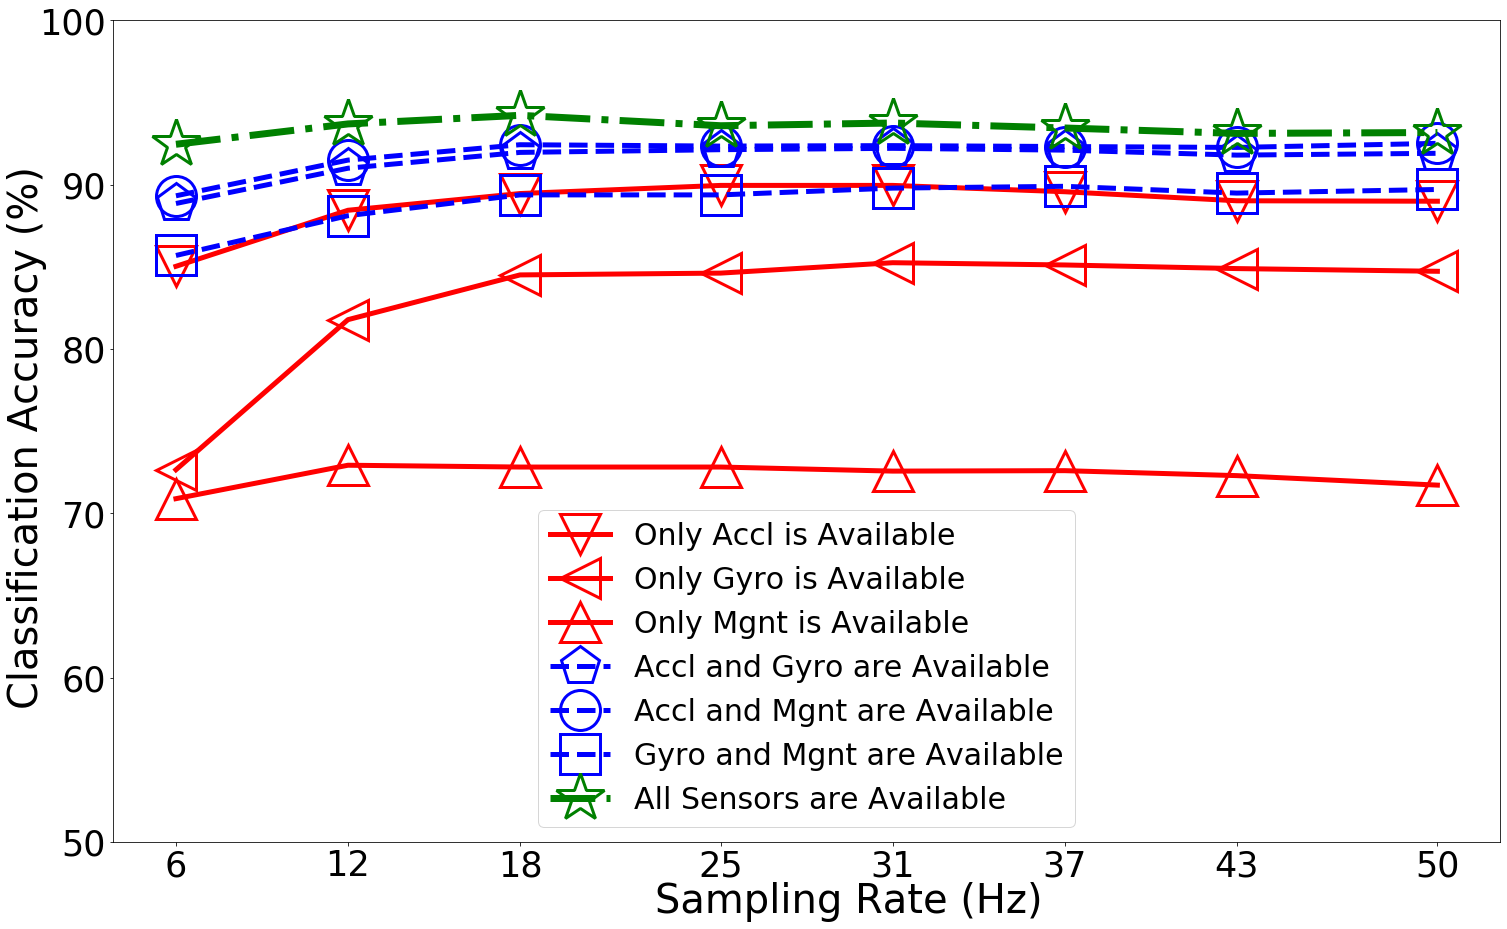

In [ ]:
import matplotlib.pyplot as plt
labels = ["Only Accl is Available", "Only Gyro is Available", "Only Mgnt is Available",
         "Accl and Gyro are Available", "Accl and Mgnt are Available", "Gyro and Mgnt are Available",
         "All Sensors are Available "]
markers = ["-vr","-<r", "-^r",
           "--pb", "--ob", "--sb", 
           "-.*g"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,12))
fig.tight_layout()
for i in range(len(H_combinations_validation)):
    y_data = best_accuracy_record[:,i]*100
    x_data = np.floor(np.array(W_combinations)/(2.56))
    if i == len(H_combinations_validation)-1:
        ax.plot(x_data, y_data, markers[i], label=labels[i], markersize= 50, linewidth=7,
            markerfacecolor="None",  markeredgewidth=3)    
    else:
        ax.plot(x_data, y_data, markers[i], label=labels[i], markersize= 40, linewidth=5,
            markerfacecolor="None",  markeredgewidth=3)    
    
ax.set_xticks(x_data)
plt.setp(ax.get_xticklabels(), fontsize=35)    
ax.set_yticks(np.arange(50,101,10))
plt.setp(ax.get_yticklabels(), fontsize=35)

fig.text(0.4, -0.05, "Sampling Rate (Hz)", size = 40)
fig.text(-0.05, 0.5, "Classification Accuracy (%)", va='center', rotation='vertical', size = 40)
ax.legend(loc= "lower center",prop={'size': 30}, ncol=1)
plt.show()